### A notebook to support academic question exploration and literature search / what do you do when you search the literature?

0. Define a research question e.g Is occupational **asbestos exposure** an underecognised **cause** of IPF? 
1. Consider the different possible ways of answering the question (methods). Different study designs and ways of measuring asbestos exposure e.g Epidemiological, observational, cross-sectional, cohort, case-control, post-mortem and explant studies, ecological, toxicology, animal models, molecular disease models, exposure assessment, occupational hygeinst measurements, minerologic analysis (tissue, BAL etc)
2. Generate search terms e.g "IPF", "case-control", "occupational", "asbestos" (? && mesh terms)
3. Carry out search using search terms and e.g pubmed, embase, google scholar, scopus, biorxiv, web of science, clinicaltrials.gov, ?google books, prepubmed.org
4. Search results == Candidate Papers
5. Extract title | journal | author | location | year | abstract | key words | full text && save result (as .bib) (prob want to export to jabref) https://stackoverflow.com/questions/30768745/is-there-a-reliable-python-library-for-taking-a-bibtex-entry-and-outputting-it-i
6. Review Candidate Papers to identify Relevant Papers 
7. Use Relevant Papers to identify more Candidate papers. Search also by author, cited by, cite, [triangle closing](https://en.wikipedia.org/wiki/Triadic_closure) e.g https://github.com/hinnefe2/bibcheck.py and other means (?tensorflow/scikit-learn,nltk), https://en.wikipedia.org/wiki/Jaccard_index, networkx?
8. Use the Relevant Papers collected for whatever it is they are relevant for (usually to help compose a written document in which they are cited). Including exporting to a nice table for LaTeX.
9. ?django app times

general discussion of the problem: 1. http://drugmonkey.scientopia.org/2010/09/28/on-keeping-abreast-of-the-literature-a-highly-loaded-poll-question/ 2. http://www.sciencemag.org/careers/2016/11/how-keep-scientific-literature

meta: github/stack exchange etc to check out other peoples search strategies. this is likely to be formulated as a machine learning problem somewhere.

#### interesting related I found includes: https://www.projectcredo.com/, http://citationexplorer.hoppmann.me/, lict from a previous nhshackday, https://github.com/jvoytek/pubmedbrain/blob/f5170a2e3540e0c2aa665559c86048dfb1583f16/documents/Voytek-brainSCANrPreprint.pdf, https://github.com/graeham/hackathon/blob/master/paperGraph.py

### search github for relevant stuff with the following 'webbit' 
> https://github.com/search?l=Python&q=http%3A%2F%2Feutils.ncbi.nlm.nih.gov%2Fentrez%2Feutils%2Fesearch.fcgi++stars%3A%3E5&ref=advsearch&type=Code&utf8=%E2%9C%93

gists and interwebs inc stackoverflow also helpful

tempting to dive into django a la https://github.com/afouchet/OpenReview but probably not essential and now is not optimal timing

https://github.com/gui11aume looks well documented, poss useful template
https://github.com/swcarpentry/2013-08-23-harvard/blob/b2097bc20833e0a58b2e73eecd1227d61bd5a00a/lessons/misc-biopython/eutils.md looks like nice intro to biopython utils and https://gist.github.com/bonzanini/5a4c39e4c02502a8451d, https://gist.github.com/ehazlett/1104507, https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 (for use of icite), https://gist.github.com/mcfrank/c1ec74df1427278cbe53, http://stackoverflow.com/questions/17409107/obtaining-data-from-pubmed-using-python, https://github.com/bwallace/abstrackr-web/tree/master/abstrackr, http://www.billconnelly.net/?p=44

### let's tackle pubmed first

In [1]:
"""
Notebook to support academic question exploration and literature search.

Thanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and 
http://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/ and vtrubets
https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 

Pubmed advanced search is helpful for designing search/experimenting 
https://www.ncbi.nlm.nih.gov/pubmed/advanced

Docs for NCBI esearch:
https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch
https://www.nlm.nih.gov/bsd/mms/medlineelements.html
"""


'\nNotebook to support academic question exploration and literature search.\n\nThanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and \nhttp://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/ and vtrubets\nhttps://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 \n\nPubmed advanced search is helpful for designing search/experimenting \nhttps://www.ncbi.nlm.nih.gov/pubmed/advanced\n\nDocs for NCBI esearch:\nhttps://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch\nhttps://www.nlm.nih.gov/bsd/mms/medlineelements.html\n'

In [66]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm
from collections import Counter, OrderedDict
import json
import requests
import re
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
def get_chunked_pmids(term, chunksize=50):
    """
    Return a list of Pubmed ids from pubmed search in chunks
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    count_handle = Entrez.esearch(db="pubmed",
                                  term=term,
                                  retmode="xml",
                                  rettype="count")
    count_results = Entrez.read(count_handle)
    count = int(count_results["Count"])

    retmax_requests = list(range(chunksize, count, chunksize))
    retmax_requests.append(count - retmax_requests[len(retmax_requests) - 1])

    for i, retmax in enumerate(retmax_requests):
        pmid_handle = Entrez.esearch(db="pubmed",
                                     term=term,
                                     sort="relevance",
                                     retmode="xml",
                                     usehistory='y',
                                     retstart=retmax,
                                     retmax=chunksize)
        results = Entrez.read(pmid_handle)
        yield results["IdList"]

In [4]:
def get_pubmed_summaries(pubmed_id):
    """
    Use the Pubmed API to return a json summary of a list of pmid strings 
    """
    pubmed_id = ','.join(pubmed_id) # citation api likes to take a single string

    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.esummary(db='pubmed', 
                             id=pubmed_id, 
                             retmode='json',
                             rettype='abstract')
    return json.loads(handle.read())['result']
  

In [5]:
def get_pubmed_keywords(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the key words for each pmid in a
    a list of pmid strings. Returns {pmid:[list of keywords]}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    keywords = {}
    for record in records:
        pmid = record.get('PMID','?')
        mh = record.get('MH','?')
        keywords[pmid] = mh
    return keywords

In [6]:
def get_pubmed_abstracts(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the abstract for each pmid in a list
    of pmid strings. Return {pmid:abstract}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    abstracts = {}
    for record in records:
        pmid = record.get('PMID','?')
        ab = record.get('AB','?')
        abstracts[pmid] = ab
    return abstracts

In [7]:
def get_pubmed_pubtypes(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the publication type for each pmid
    in a list of pmid strings. Return {pmid:pubtype}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    pubtypes = {}
    for record in records:
        pmid = record.get('PMID','?')
        pt = record.get('PT','?')
        pubtypes[pmid] = pt
    return pubtypes

In [8]:
def get_citation_information(pubmed_id):
    """
    Use the special citation api to return relative citation ratios
    Takes a list of pmid strings. Returns {pmid:rcr}
    """
    pubmed_id = ','.join(pubmed_id) # citation api likes to take a single string
    citation_search = 'https://icite.od.nih.gov/api/pubs?pmids={0}'.format(pubmed_id)
    response = requests.get(citation_search).content
    str_response = response.decode('utf-8')
    
    try:
        data = json.loads(str_response)['data']
    except KeyError:
        data = False
         
    citations = {}
    
    if data:
        for record in data:
            pmid = record.get('pmid')
            rcr = record.get('relative_citation_ratio')
            citations[pmid] = rcr
    return citations
        

In [9]:
def get_pmids_for_papers_citing(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for a paper citing a *single pmid*
    Return list of citing pmids.
    see also https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.elink(dbfrom="pubmed",
                          id=pubmed_id,
                          linkname="pubmed_pubmed_citedin")
    records = Entrez.read(handle)
    list_of_pmids_citing = []
    
    if records[0]["LinkSetDb"]:
        for link in records[0]["LinkSetDb"][0]["Link"]:
            list_of_pmids_citing.append(link["Id"]) 
  
    return list_of_pmids_citing 

In [10]:
def get_pmids_for_papers_cited(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for papers cited by a particular pmid
    Return list of pmids. *only works for papers in pubmed central*
    see also https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.elink(dbfrom="pubmed",
                          id=pubmed_id,
                          linkname="pubmed_pubmed_refs")
    records = Entrez.read(handle)
    list_of_pmids_cited = []
    
    if records[0]["LinkSetDb"]:
        for link in records[0]["LinkSetDb"][0]["Link"]:
            list_of_pmids_cited.append(link["Id"]) 
    return list_of_pmids_cited

In [11]:
def get_cited_pmids(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for a paper cited by pmid
    in a list of pmids. Return {pmid:list_of_citing_pmids}
    Only works for papers in PMC
    """
    cited = {}
    for pmid in pubmed_id:
        cited[pmid] = get_pmids_for_papers_cited(pmid)
    return cited

In [12]:
def get_citing_pmids(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for a paper citing a pmid
    in a list of pmids
    Return {pmid:list_of_citing_pmids}
    """
    citing = {}
    for pmid in pubmed_id:
        citing[pmid] = get_pmids_for_papers_citing(pmid)
  
    return citing

In [13]:
def lit_fetch(pubmed_id):
    """
    Search pubmed for a list of pmid strings and return information about the results
    """
    result = {}
    result['summaries'] = get_pubmed_summaries(pubmed_id)
    result['pubtypes'] = get_pubmed_pubtypes(pubmed_id)
    result['abstracts'] = get_pubmed_abstracts(pubmed_id)
    result['keywords'] = get_pubmed_keywords(pubmed_id)
    result['rcrs'] = get_citation_information(pubmed_id)
    result['citing'] = get_citing_pmids(pubmed_id)
    result['cited'] = get_cited_pmids(pubmed_id)
    return result
        

In [14]:
def resultdf(r):
    df = pd.DataFrame(r['summaries']['uids'], columns=['pmid'])
    df['title'] = df['pmid'].map(lambda x: r['summaries'].get(x)['title'])
    df['firstauthor'] = df['pmid'].map(lambda x: r['summaries'].get(x)['sortfirstauthor'])
    df['lastauthor'] = df['pmid'].map(lambda x: r['summaries'].get(x)['lastauthor'])
    df['journal'] = df['pmid'].map(lambda x: r['summaries'].get(x)['source'])
    df['pubdate'] = df['pmid'].map(lambda x: r['summaries'].get(x)['sortpubdate'])
    df['pubtype'] = df['pmid'].map(lambda x: r['pubtypes'].get(x))
    df['abstract'] = df['pmid'].map(lambda x: r['abstracts'].get(x))
    df['keywords'] = df['pmid'].map(lambda x: r['keywords'].get(x))
    df['rcr'] = df['pmid'].astype(int).map(lambda x: r['rcrs'].get(x))
    df['citedby'] =  df['pmid'].map(lambda x: r['citing'].get(x))
    df['cites'] = df['pmid'].map(lambda x: r['cited'].get(x))
    pd.set_option('max_colwidth',300)
    return df

In [15]:
def save_df_as_csv(term, df):
    name = term.replace(" ", "-")
    df.to_csv(name+".csv")

In [16]:
def lit_search(term):
    """
    Search pubmed for a term and collect information about the results
    """
    pmid_blocks = get_chunked_pmids(term, chunksize=200)
    df_list = []
    for i, block in enumerate(pmid_blocks):
        if i < 1:
            print("Beginning block processing")
            result = lit_fetch(block)
            df = resultdf(result)
            df_list.append(df)
            print("Processed block {0}".format(i))
    df = pd.concat(df_list)
    save_df_as_csv(term, df)
    return df
        

In [17]:
def explore_result_dataframe(df):
    """
    Print some simple stats for result dataframe
    """
    print('Top first authors\n')
    print(df.firstauthor.value_counts().head())
    print('\nTop last authors\n')
    print(df.lastauthor.value_counts().head())
    print('\nTop journals\n')
    print(df.journal.value_counts().head())
    print('\nTop publication types\n')
    print(df.pubtype.astype(str).value_counts().head())
    print('\nPublications per year\n')
    df.pubdate = pd.to_datetime(df.pubdate)
    df.index = df.pubdate
    df.groupby(df.pubdate.map(lambda x: x.year)).pmid.count().plot(kind='bar')


Beginning block processing
Processed block 0
Top first authors

Richeldi L    4
Behr J        4
Cottin V      4
Raghu G       3
Poletti V     2
Name: firstauthor, dtype: int64

Top last authors

Collard HR    7
King TE Jr    3
Cottin V      3
Ryu JH        3
Behr J        3
Name: lastauthor, dtype: int64

Top journals

Eur Respir J                 13
Am J Respir Crit Care Med    11
PLoS One                      9
Respir Med                    9
Eur Respir Rev                8
Name: journal, dtype: int64

Top publication types

['Journal Article', "Research Support, Non-U.S. Gov't"]              42
['Journal Article']                                                  37
['Journal Article', 'Review']                                        30
['Journal Article', "Research Support, Non-U.S. Gov't", 'Review']    11
['Comparative Study', 'Journal Article']                              6
Name: pubtype, dtype: int64

Publications per year



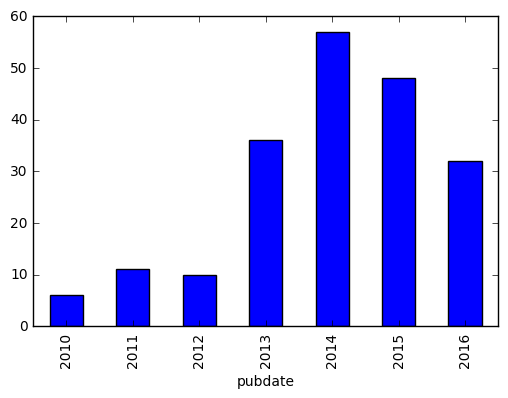

In [18]:
df = lit_search('idiopathic pulmonary fibrosis')
explore_result_dataframe(df)

In [19]:
pmid_blocks = get_chunked_pmids('idiopathic pulmonary fibrosis', chunksize=200)


In [20]:
terms = ['idiopathic pulmonary fibrosis', 'cryptogenic fibrosing alveolitis',
        'usual interstitial pneumonia', 'asbestosis']

#?(idiopathic pulmonary fibrosis) AND (asbestos) 

def litsearch_terms(terms):
    """
    Search pubmed for the terms and return a df
    """
    df_list = []
    for term in terms:
        print ('searching for {0}'.format(term))
        df = lit_search(term)
        df_list.append(df)
        save_df_as_csv(term, df)
    df = pd.concat(df_list)
    return df

In [21]:
topic_collection = {"ipfjes_case_control_studies" : ['23022860', '10968375', '24413348', '19782552', '17628464', 
                                                     '10841131', '8569361', '8087336', '15640309', '9571528', 
                                                     '18507288', '23022860', '2249047'], 
                    "ipfjes_reviews" : ['25621562', '24348069', '10193340', '11816818', '15331187', '16733403']}


def litfetch_topics(topic_collection):
    """
    fetch info for pmids in a topic collection and save the result as a .csv
    """
    for topic in topic_collection:
        print('begining topic {0} analaysis'.format(topic))
        result = lit_fetch(topic_collection[topic])
        df = resultdf(result)
        save_df_as_csv(topic, df)
        print('csv of topic {0} saved'.format(topic))

In [22]:
df = pd.read_csv('idiopathic-pulmonary-fibrosis.csv', usecols=['pmid','title','firstauthor','lastauthor',
                                                             'journal','pubdate','pubtype',
                                                             'abstract', 'keywords', 'rcr'])

In [23]:
df = pd.read_csv('ipfjes_case_control_studies.csv', usecols=['pmid','title','firstauthor','lastauthor',
                                                             'journal','pubdate','pubtype',
                                                             'abstract', 'keywords', 'rcr', 'citedby', 'cites'])


In [24]:
df1 = pd.read_csv('idiopathic-pulmonary-fibrosis.csv', usecols=['pmid','title','firstauthor','lastauthor',
                                                             'journal','pubdate','pubtype',
                                                             'abstract', 'keywords', 'rcr', 'citedby'])

In [25]:
keywords = get_pubmed_keywords(topic_collection['ipfjes_case_control_studies'])

print ('Top pubmed keywords (mesh headings)',
       'for the {0} occupational IPF case-control studies found'.format(len(keywords)))

corpus = []
       
for record in keywords:
    corpus.append(keywords[record])
    
corpus = [item for sublist in corpus for item in sublist]

x = Counter(corpus)

top_keywords = [(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)]
top_keywords[:5]

Top pubmed keywords (mesh headings) for the 12 occupational IPF case-control studies found


[('Male', 12),
 ('Humans', 12),
 ('Female', 12),
 ('Case-Control Studies', 10),
 ('Aged', 8)]

In [26]:
def citing_count(pubmed_id):
    '''
    Looks up papers citing a list of pubmed_id strings and returns a dict
    {citing_paper:number_of_times_cites_list}
    '''
    citing = get_citing_pmids(pubmed_id)
    corpus = []
    for record in citing:
        corpus.append(citing[record])
    corpus = [item for sublist in corpus for item in sublist]
    x = Counter(corpus)
    citingpapers = [(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)]
    citing_count = dict(citingpapers)
    return citing_count

In [27]:
citing_count = citing_count(topic_collection['ipfjes_case_control_studies'])

In [28]:
result = lit_fetch(list(citing_count.keys()))


In [29]:
df = resultdf(result)

In [36]:
df.head()

,pmid,title,firstauthor,lastauthor,journal,pubdate,pubtype,abstract,keywords,rcr,citedby,cites
0,14760762,Values of high-resolution computed tomography and pulmonary function tests in managements of patients with chronic hepatitis C virus infection.,Okutan O,Silit E,World J Gastroenterol,2004/02/01 00:00,[Journal Article],AIM: To investigate pulmonary involvement via pulmonary function tests (PFT) and high-resolution computed tomography (HRCT) in patients with chronic hepatitis C virus (HCV) infection. METHODS: Thirty-four patients with chronic HCV infection without diagnosis of any pulmonary diseases and 10 heal...,"[Adult, Aged, Female, Hepatitis C, Chronic/*complications, Humans, Lung Diseases/*diagnosis/*virology, Male, Middle Aged, *Respiratory Function Tests, *Tomography, X-Ray Computed/methods]",0.247526,[],"[9787595, 9305658, 9230228, 9133969, 8569361, 8553934, 8520769, 8260706, 8184045, 7880199, 7810933, 7597444, 7504894, 7308988, 6148520, 2805833, 2500296, 2249047, 1549829, 1320820]"
1,23153608,Newly recognized occupational and environmental causes of chronic terminal airways and parenchymal lung disease.,Sauler M,Gulati M,Clin Chest Med,2012/12/01 00:00,"[Journal Article, Review]","With the introduction of new materials and changes in manufacturing practices, occupational health investigators continue to uncover associations between novel exposures and chronic forms of diffuse parenchymal lung disease and terminal airways disease. To discern exposure-disease relationships,...","[Chronic Disease, Diacetyl/toxicity, Environmental Exposure/*adverse effects, Humans, Indium/toxicity, Lung Diseases/*etiology, Lung Diseases, Interstitial/etiology, Nanoparticles/toxicity, Nylons/toxicity, Occupational Diseases/*etiology, Occupational Exposure/adverse effects, Population Survei...",1.008971,[24472147],"[23236631, 22269741, 22207675, 21932425, 21917441, 21860325, 21642248, 21606847, 21298693, 21063190, 21057497, 20972355, 20886351, 20550761, 20427587, 20368128, 20019344, 19834281, 19590695, 18678700, 18474946, 18308961, 18260313, 18227102, 17628464, 17590529, 17541015, 17400664, 17400659, 17119..."
2,26934369,Cigarette Smoke Enhances the Expression of Profibrotic Molecules in Alveolar Epithelial Cells.,Checa M,Selman M,PLoS One,2016/03/02 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]","Idiopathic pulmonary fibrosis (IPF) is a progressive and lethal disease of unknown etiology. A growing body of evidence indicates that it may result from an aberrant activation of alveolar epithelium, which induces the expansion of the fibroblast population, their differentiation to myofibroblas...","[Animals, Antigens, Neoplasm/genetics/metabolism, Cell Line, Epithelial Cells/cytology/metabolism/*pathology, Epithelial-Mesenchymal Transition, Fibroblasts/cytology/metabolism/*pathology, Gene Expression Regulation, Humans, Idiopathic Pulmonary Fibrosis/etiology/genetics/metabolism/pathology, I...",NaN,[27897264],"[25329389, 25141943, 24605795, 23583980, 22434388, 22011363, 21719092, 19924381, 19251946, 19147812, 18478089, 18318599, 17200183, 16738192, 16646809, 16109978, 16045796, 15640309, 15564020, 12842806, 12791580, 12740284, 12582260, 12133818, 11704535, 11177318, 10025398, 9843857, 8569361, 8314838..."
3,24746870,Epigenetics of idiopathic pulmonary fibrosis.,Yang IV,Schwartz DA,Transl Res,2015/01/01 00:00,"[Journal Article, Research Support, N.I.H., Extramural, Research Support, U.S. Gov't, Non-P.H.S., Review]","Idiopathic pulmonary fibrosis (IPF) is a complex lung disease of unknown etiology. Development of IPF is influenced by both genetic and environmental factors. Recent work by our and other groups has identified strong genetic predisposition factors for the development of pulmonary fibrosis, and c...","[Animals, Environmental Exposure/adverse effects, *Epigenesis, Genetic, Genetic Predisposition to Disease, Humans, Idiopathic Pulmonary Fibrosis/*etiology/*genetics/physiopathology, MicroRNAs/genetics/metabolism, Risk Facto

In [30]:
citing_count.get('10193340')

3

In [37]:
df.pubdate = pd.to_datetime(df.pubdate)
df.index = df.pubdate.map(lambda x: x.year)
df = df.sort_values(by = 'pubdate', ascending=True)
df['citations of pmidgrp'] = df.pmid.map(lambda x: citing_count.get(x))
df = df[['title','firstauthor', 'lastauthor', 'journal', 'pubtype', 'rcr', 'citations of pmidgrp']]
df

,title,firstauthor,lastauthor,journal,pubtype,rcr,citations of pmidgrp
pubdate,,,,,,,
1991,Critical appraisal of published research: introductory guidelines.,Fowkes FG,Fulton PM,BMJ,"[Guideline, Journal Article]",NaN,1
1992,"New perspectives on basic mechanisms in lung disease. 1. Lung injury, inflammatory mediators, and fibroblast activation in fibrosing alveolitis.",Sheppard MN,Harrison NK,Thorax,"[Journal Article, Review]",NaN,1
1995,Epstein-Barr virus replication within pulmonary epithelial cells in cryptogenic fibrosing alveolitis.,Egan JJ,Woodcock AA,Thorax,"[Journal Article, Research Support, Non-U.S. Gov't]",3.073204,1
1996,Mortality rates from cryptogenic fibrosing alveolitis in seven countries.,Hubbard R,Britton J,Thorax,[Journal Article],2.405705,2
1997,British Thoracic Society study of cryptogenic fibrosing alveolitis: current presentation and initial management. Fibrosing Alveolitis Subcommittee of the Research Committee of the British Thoracic Society.,Johnston ID,Rudd RM,Thorax,"[Journal Article, Research Support, Non-U.S. Gov't]",4.620485,1
1998,In search of a cause of cryptogenic fibrosing alveolitis (CFA): one initiating factor or many?,Turner-Warwick M,Turner-Warwick M,Thorax,"[Journal Article, Review]",0.229885,3
1999,"The diagnosis, assessment and treatment of diffuse parenchymal lung disease in adults. Introduction.",,,Thorax,"[Journal Article, Review]",0.529739,1
2000,Adult familial cryptogenic fibrosing alveolitis in the United Kingdom.,Marshall RP,Laurent GJ,Thorax,"[Journal Article, Research Support, Non-U.S. Gov't]",3.413365,1
2000,Interstitial fibrosis and growth factors.,Lasky JA,Brody AR,Environ Health Perspect,"[Journal Article, Research Support, U.S. Gov't, P.H.S., Review]",1.981621,1


In [38]:
df.to_csv('papers_citing_ipf_occupational_dust_case_control_studies.csv')

In [40]:
df.sort_values(by='citations of pmidgrp', ascending=False)

,title,firstauthor,lastauthor,journal,pubtype,rcr,citations of pmidgrp
pubdate,,,,,,,
2013,Epidemiology of idiopathic pulmonary fibrosis.,Ley B,Collard HR,Clin Epidemiol,"[Journal Article, Review]",3.114474,10
2011,New insights into the pathogenesis and treatment of idiopathic pulmonary fibrosis.,Ding Q,Thannickal VJ,Drugs,"[Journal Article, Research Support, N.I.H., Extramural, Research Support, Non-U.S. Gov't, Review]",1.379412,9
2015,Asbestosis and environmental causes of usual interstitial pneumonia.,Gulati M,Redlich CA,Curr Opin Pulm Med,"[Journal Article, Review]",0.943542,8
2014,"Effects of smoking, gender and occupational exposure on the risk of severe pulmonary fibrosis: a population-based case-control study.",Ekström M,Torén K,BMJ Open,"[Journal Article, Research Support, Non-U.S. Gov't]",1.144405,8
2009,Cigarette smoking is associated with subclinical parenchymal lung disease: the Multi-Ethnic Study of Atherosclerosis (MESA)-lung study.,Lederer DJ,Barr RG,Am J Respir Crit Care Med,"[Journal Article, Research Support, N.I.H., Extramural, Research Support, Non-U.S. Gov't]",3.310302,5
2016,Idiopathic Pulmonary Fibrosis: A Genetic Disease That Involves Mucociliary Dysfunction of the Peripheral Airways.,Evans CM,Schwartz DA,Physiol Rev,"[Journal Article, Review]",NaN,5
2004,The epidemiology of interstitial lung disease and its association with lung cancer.,Raghu G,Morgan G,Br J Cancer,"[Journal Article, Review]",1.747284,4
2012,Newly recognized occupational and environmental causes of chronic terminal airways and parenchymal lung disease.,Sauler M,Gulati M,Clin Chest Med,"[Journal Article, Review]",1.008971,4
2014,Idiopathic pulmonary fibrosis: early detection and referral.,Oldham JM,Noth I,Respir Med,"[Journal Article, Research Support, Non-U.S. Gov't, Review]",1.139613,4


In [41]:
# make something to show new things

In [59]:
cited = get_cited_pmids(topic_collection['ipfjes_case_control_studies'])

# print ('Top cited papers (from pubmed)',
#       'for the {0} occupational IPF case-control studies found'.format(len(cited)))

corpus = []
       
for record in cited:
    corpus.append(cited[record])
    
corpus = [item for sublist in corpus for item in sublist]

x = Counter(corpus)

# [(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)] not that interesting because most
# of our papers aren't in PMC and so citations not available

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

IPF case-control studies and their citing papers

Key : pubmed id : title author year : (n of citations)
0 : 8569361 : Occupational exposure to metal or wood dust and aetiology of cryptogenic fibrosing alveolitis. Hubbard R 1996 (40)
1 : 10968375 : Occupational and environmental risk factors for idiopathic pulmonary fibrosis: a multicenter case-control study. Collaborating Centers. Baumgartner KB 2000 (39)
2 : 8087336 : Idiopathic pulmonary fibrosis. Epidemiologic approaches to occupational exposure. Iwai K 1994 (30)
3 : 2249047 : What causes cryptogenic fibrosing alveolitis? A case-control study of environmental exposure to dust. Scott J 1990 (24)
4 : 15640309 : Occupational and environmental factors and idiopathic pulmonary fibrosis in Japan. Miyake Y 2005 (11)
5 : 10841131 : Risk of cryptogenic fibrosing alveolitis in metal workers. Hubbard R 2000 (9)
6 : 19782552 : Risk factors for idiopathic pulmonary fibrosis in a Mexican population. A case-control study. García-Sancho Figueroa M

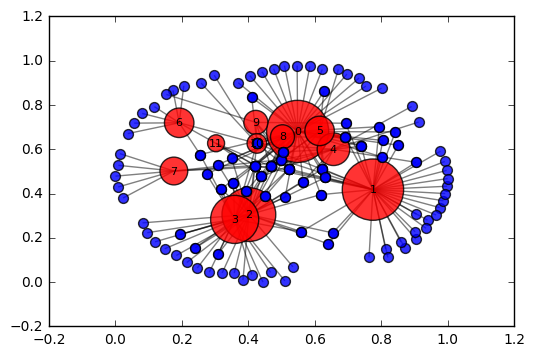

In [98]:
# G = nx.DiGraph(nx.from_dict_of_lists(citing))
citing = get_citing_pmids(topic_collection['ipfjes_case_control_studies'])

citing = OrderedDict(sorted(citing.items(), key=lambda t: len(t[1])))

citing = OrderedDict(reversed(list(citing.items())))

G = nx.from_dict_of_lists(citing)

pos=nx.spring_layout(G)
        
nx.draw_networkx_nodes(G,pos,
                       nodelist=citing.keys(),
                       node_color='r',
                       node_size=[len(v) * 50 for v in citing.values()],
                       alpha=0.8)

nx.draw_networkx_nodes(G,pos,
                       nodelist=[item for sublist in citing.values() for item in sublist],
                       node_color='b',
                       node_size=50,
                       alpha=0.8)

nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)

labels = {}

for i, item in enumerate(citing):
    labels[item] = i
    
nx.draw_networkx_labels(G,pos,labels,font_size=8)

print ('IPF case-control studies and their citing papers\n')
    
    
print ('Key : pubmed id : title author year : (n of citations)')

for i, item in enumerate(citing):
    print(i,':', item, ':', get_pubmed_summaries([item])[item]['title'],
          get_pubmed_summaries([item])[item]['sortfirstauthor'], 
          get_pubmed_summaries([item])[item]['sortpubdate'][:4],
          '({0})'.format(len(citing[item])))
    
plt.savefig('PapersThatIPFCaseControlStudies.png')

In [ ]:
# need to sort paper (and label order)
# consider weighting size of citing papers by RSI
# classification
# flask app
# ?hover over labels in networkx
# http://nbviewer.jupyter.org/urls/ep2016.europython.eu/media/conference/slides/networkx-visualization-powered-by-bokeh.ipynb
# https://github.com/bokeh/bokeh/blob/master/examples/plotting/file/graphs.py
# https://andrewmellor.co.uk/blog/articles/2014/12/14/d3-networks/